In [1]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import jit, lax

In [2]:
# Read in grid 
from base.initial_condition import InitialField
from basic.cfdStartSession import cfdPrintMainHeader, cfdSetupRegion, cfdPrintCaseDirectoyPath
from mesh.setup import cfdSetupMesh
from mesh.process import cfdProcessTopology
from utilities.IO.Foam import cfdReadPolyMesh, cfdReadControlDictFile, cfdReadFvSchemes, cfdReadFvSolutions, cfdReadTimeDirectory, cfdReadTransportProperties

In [3]:
cfdPrintMainHeader()
# myRegion = cfdSetupRegion(path='step_profile')
myRegion = cfdSetupRegion(path='Euler')
cfdPrintCaseDirectoyPath(myRegion)
cfdSetupMesh(myRegion)
cfdReadPolyMesh(myRegion)
cfdReadControlDictFile(myRegion)
cfdReadFvSchemes(myRegion)
cfdReadFvSolutions(myRegion)
cfdProcessTopology(myRegion)
cfdReadTimeDirectory(myRegion)
# skipping the mesh io waiting for yongqi to complete. 
# from base.grids import Grid,BoundaryConditions
# grid = Grid(np.load("./mesh_basic_np.npz"))
grid = myRegion.mesh 

# u = InitialField('U',myRegion)
T = InitialField('T',myRegion)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-* GraphFVM *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

|| Written by Pan Du from University of NotreDame.   ||

|| An academic CFD package developed for learning purposes to serve ||

|| the student community.                                           ||

----------------------------------------------------------------------

 Credits:
 	Pan Du, Jian-Xun Wang

\pdu@nd.edu

	University Of Notre Dame

	GraphFVM v1.0, 2024


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


Simulation Directory:  Euler
Reading points file ...
Reading faces file ...
Reading owner file ...
Reading neighbour file ...
Reading boundary file ...
processing mesh ...
Converting mesh to jax mesh ...
{'FoamFile': {'version': '2.0', 'format': 'ascii', 'class': 'volScalarField', 'object': 'T'}, 'dimensions': '[0 0 0 1 0 0 0]', 'internalField': 'uniform 10.0', 'boundaryField': {'bottom': {'type': 'fixedValue', 'value': 'uniform 10.0'}, 'top': {'type': 'fixedValue', 'value': '

In [4]:
def get_gt_grad2foi(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    return (
        1000
        * x
        * z
        * (
            12 * x**2 * y * z * (x - 1) * (y - 1) * jnp.sin(jnp.pi * y)
            + x**2
            * (x - 1)
            * (z**3 - 1)
            * (
                -jnp.pi**2 * y * (y - 1) * jnp.sin(jnp.pi * y)
                + 2 * jnp.pi * y * jnp.cos(jnp.pi * y)
                + 2 * jnp.pi * (y - 1) * jnp.cos(jnp.pi * y)
                + 2 * jnp.sin(jnp.pi * y)
            )
            - 2
            * y
            * (y - 1)
            * (z**3 - 1)
            * (2 * x**4 * (1 - x) + 2 * x**3 + 7 * x**2 * (x - 1) - 6 * x + 3)
            * jnp.sin(jnp.pi * y)
        )
        * jnp.exp(-(x**2))
    )

def get_source(X,t):
    """
    according to grad(-gamma*grad(phi)) = source
    """
    return -get_gt_grad2foi(X)*jnp.sin(jnp.pi*t)

Simulation_input = {
    'rho': jnp.ones(grid.n_cells),
}
grid.SetUpSimulation( **Simulation_input)

In [5]:
grid.ddtSchemes

'Euler'

In [6]:
grid.snGradSchemes

'corrected'

In [7]:
grid.gradSchemes

'Gauss linear'

In [8]:
from jax import lax,jit
from functools import partial
from solver.pdeSolver import LaplacianJax_jit

step_fn = partial(LaplacianJax_jit, grid=grid, source_function = get_source)
step_fn = jit(step_fn,static_argnums=1)

from typing import Callable
def repeated(f: Callable, steps: int) -> Callable:
    """Returns a repeatedly applied version of f()."""

    def f_repeated(x_initial):
        g = lambda x, _: f(x)
        x_final, analysis = lax.scan(g, x_initial, xs=None, length=steps)
        return x_final, analysis

    return f_repeated

repeated_fn = repeated(step_fn, 20)
rollout_fn = jit(repeated_fn)
def wrapper2():
    return rollout_fn(T)  # .block_until_ready()
outputs3 = wrapper2()

/home/yongqi/.conda/envs/jaxEnv/lib/python3.10/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(1,), but only accepts 1 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [9]:
from mesh.IO import read_openfoam_filed
openfoam_result = []
for i in range(1,len(outputs3[1]['phi'])+1):  # Loop through 11 time steps (from 0.0 to 0.1)
    if i == 0:
        file_path = f'Euler/{0}/T'
    else :
        time_step = i * 0.1  # Increment time step by 0.01
        file_path = f'Euler/{time_step:.3g}//T'  # Format time step to two decimal places
    openfoam_result.append(read_openfoam_filed(file_path))

openfoam_result = jnp.array(openfoam_result)

Averaged relative abs error at time step 1: 1.3760165172036507e-10
Averaged relative abs error at time step 2: 4.556600282488299e-10
Averaged relative abs error at time step 3: 1.0449963772099136e-09
Averaged relative abs error at time step 4: 1.603793927306713e-09
Averaged relative abs error at time step 5: 1.8708400119703744e-09
Averaged relative abs error at time step 6: 2.1156784514072404e-09
Averaged relative abs error at time step 7: 1.7909480175898316e-09
Averaged relative abs error at time step 8: 1.986814393371285e-09
Averaged relative abs error at time step 9: 1.6860519222148893e-09
Averaged relative abs error at time step 10: 1.0052152944324302e-09
Averaged relative abs error at time step 11: 4.950819699321279e-10
Averaged relative abs error at time step 12: 4.5832054304501686e-10
Averaged relative abs error at time step 13: 7.419355607136378e-10
Averaged relative abs error at time step 14: 1.1890915818216365e-09
Averaged relative abs error at time step 15: 1.413183882386941

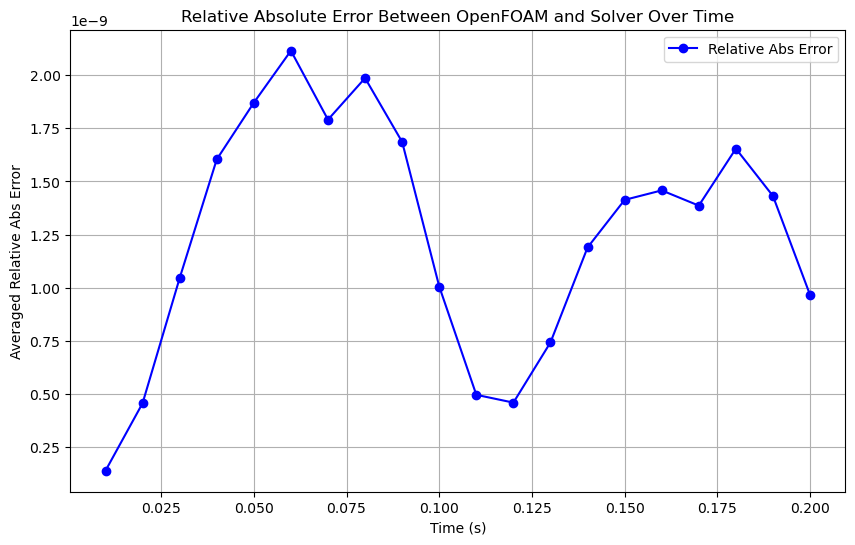

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Initialize a list to store relative absolute errors for each time step
relative_abs_errors = []

# Loop through time steps and calculate the relative absolute error
for i in range(len(outputs3[1]['phi'])):
    error = jnp.mean(jnp.abs((outputs3[1]['phi'][i] - openfoam_result[i]) / openfoam_result[i]))
    relative_abs_errors.append(error)
    print(f'Averaged relative abs error at time step {i+1}: {error}')

# Plot the relative absolute error over time steps
time_steps = [i * 0.01 for i in range(1, len(outputs3[1]['phi'])+1)]  # Time steps from 0.01 to 0.10

plt.figure(figsize=(10, 6))
plt.plot(time_steps, relative_abs_errors, marker='o', linestyle='-', color='b', label='Relative Abs Error')
plt.title('Relative Absolute Error Between OpenFOAM and Solver Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Averaged Relative Abs Error')
plt.grid(True)
plt.legend()
plt.show()